## Residual UNET

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from tqdm import tqdm
import json
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.style.use('dark_background')
print("Using device : ",device)

Using device :  cuda


In [28]:
# Paths
NOTEBOOK_DIR = Path().resolve()
BASE_DIR = NOTEBOOK_DIR.parents[1]
DATASET_DIR = BASE_DIR / "data"
MODEL_OUTPUT_DIR = BASE_DIR / "models" / "1-residual-block" 
MODEL_OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

INPUT_DIR  = DATASET_DIR / "inputs"
TARGET_DIR = DATASET_DIR / "targets"
HEIGHT , WIDTH = 256 , 256
IMAGE_SIZE = (HEIGHT , WIDTH)
import sys
sys.path.append(str(BASE_DIR))
import helper

for name, directory in [("Input", INPUT_DIR), ("Target", TARGET_DIR)]:
    if directory.is_dir():
        files = list(directory.glob('*'))
        print(f"✅ {name} Directory: {'Contains ' + str(len(files)) + ' files.' if files else 'Empty.'}")
    else:
        print(f"❌ {name} Directory NOT found at: {directory}")

✅ Input Directory: Contains 1400 files.
✅ Target Directory: Contains 1400 files.


In [30]:
class InterferogramDataset(Dataset):
    """Simple segmentation dataset for image-mask pairs"""
    
    def __init__(self, image_dir, mask_dir, transform=None, img_size=(512,512)):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.img_size = img_size
        
        # Get all image files
        valid_exts = {".jpg", ".jpeg", ".png"}
        self.images = sorted([f for f in self.image_dir.iterdir() if f.suffix.lower() in valid_exts])
        self.masks = sorted([f for f in self.mask_dir.iterdir() if f.suffix.lower() in valid_exts])
        
        assert len(self.images) == len(self.masks), "Images and masks count mismatch!"
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image and mask
        img = Image.open(self.images[idx]).convert('L')
        mask = Image.open(self.masks[idx]).convert('L')  # Grayscale
        
        # Resize
        img = img.resize(self.img_size, Image.NEAREST)
        mask = mask.resize(self.img_size, Image.NEAREST)
        
        # Convert to numpy
        img = np.array(img).astype(np.float32) / 255.0
        mask = np.array(mask).astype(np.float32) / 255.0
        
        # To tensor (C, H, W)
        img = torch.from_numpy(img).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dim
        
        return img, mask

In [31]:
# Create datasets
train_dataset = InterferogramDataset(INPUT_DIR, TARGET_DIR, img_size=IMAGE_SIZE)
BATCH_SIZE = 16
# Split into train/val (80/20)
train_size = int(0.65 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")


Train samples: 910, Val samples: 490


In [32]:
class ResidualBlock(nn.Module):
    """Residual block with two convolutions"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        
        # Skip connection
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        
    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)


In [33]:
class UNetResidualLite(nn.Module):
    """Lightweight U-Net with residual blocks for denoising / upsampling"""
    def __init__(self, in_channels=1, out_channels=1, base_filters=32):
        super().__init__()
        # Encoder
        self.enc1 = ResidualBlock(in_channels, base_filters)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = ResidualBlock(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = ResidualBlock(base_filters*2, base_filters*4)
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(base_filters*4, base_filters*2, 2, stride=2)
        self.dec2 = ResidualBlock(base_filters*4, base_filters*2)
        
        self.up1 = nn.ConvTranspose2d(base_filters*2, base_filters, 2, stride=2)
        self.dec1 = ResidualBlock(base_filters*2, base_filters)
        
        # Output
        self.out = nn.Conv2d(base_filters, out_channels, 1)
        
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        
        # Bottleneck
        b = self.bottleneck(self.pool2(e2))
        
        # Decoder
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        return self.out(d1)

In [34]:
class DiceLoss(nn.Module):
    """Dice Loss for segmentation"""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    """Combines Dice Loss and BCE"""
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super().__init__()
        self.dice = DiceLoss()
        self.bce = nn.BCELoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        
    def forward(self, pred, target):
        return self.dice_weight * self.dice(pred, target) + self.bce_weight * self.bce(pred, target)
    
def calculate_iou(pred, target, threshold=0.5):
    """Calculate IoU metric"""
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()


In [60]:
model = UNetResidualLite(in_channels=1, out_channels=1, base_filters=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
helper.inspect_model(
    model, 
    input_size=(1,1,HEIGHT,WIDTH),
    criterion=criterion,
    optimizer=optimizer,
    model_name="U-Net-Lite with Residual Connections"
)

────────────────────────────────────── U-Net-Lite with Residual Connections ───────────────────────────────────────

Architecture Summary:

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
UNetResidualLite                         [1, 1, 256, 256]          [1, 1, 256, 256]          --
├─ResidualBlock: 1-1                     [1, 1, 256, 256]          [1, 2, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 1, 256, 256]          [1, 2, 256, 256]          4
│    └─Conv2d: 2-2                       [1, 1, 256, 256]          [1, 2, 256, 256]          20
│    └─BatchNorm2d: 2-3                  [1, 2, 256, 256]          [1, 2, 256, 256]          4
│    └─ReLU: 2-4                         [1, 2, 256, 256]          [1, 2, 256, 256]          --
│    └─Conv2d: 2-5                       [1, 2, 256, 256]          [1, 2, 256, 256]          38
│    └─BatchNorm2d: 2-6                  [1, 2, 256, 256]          [1, 2, 256, 256]          4
│    └─ReLU: 2-7                         [1, 2, 256, 256]          [1, 2, 256, 256]          --
├─MaxPool2d: 1-2                      

MACs and Parameters (ptflops):

╷             
  Metric               │      Value  
 ══════════════════════╪════════════ 
  Total Parameters     │      2,065  
  Trainable Parameters │      2,065  
  Optimizer Params     │      2,065  
  Model Size (MB)      │      0.008  
  MACs                 │ 35.88 MMac  
  FLOPs (approx)       │ 35.88 MMac  
  Loss Function        │    MSELoss  
  Optimizer            │       Adam  
                       ╵

In [40]:
def train_epoch(model, loader,criterion, optimizer, device):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(loader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs , masks)  
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    n = len(loader)
    return total_loss / n 

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validation", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs , masks)  
            total_loss += loss.item()
    n = len(loader)
    return total_loss / n


In [41]:
history = {
    'train_loss': [] , 'val_loss': []
}
best_val_loss = float('inf')

In [42]:
# Training with detailed loss tracking
epochs = 25

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss = train_epoch(
        model, train_loader,criterion, optimizer, device
    )
    val_loss  = validate(
        model, val_loader ,criterion, device
    )
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    scheduler.step(val_loss)
    print(f"Loss : {'Train':<3} = {train_loss:.4f} | {'Val':<3} = {val_loss:.4f}")
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_OUTPUT_DIR /  f"best_model.pth")
        print(f" Best model saved at epoch {epoch}")

Epoch 1/25


Loss : Train = 0.8768 | Val = 0.7398
 Best model saved at epoch 0
Epoch 2/25


Loss : Train = 0.6987 | Val = 0.6267
 Best model saved at epoch 1
Epoch 3/25


Loss : Train = 0.5991 | Val = 0.5636
 Best model saved at epoch 2
Epoch 4/25


Loss : Train = 0.5352 | Val = 0.5115
 Best model saved at epoch 3
Epoch 5/25


Loss : Train = 0.4844 | Val = 0.4625
 Best model saved at epoch 4
Epoch 6/25


Loss : Train = 0.4423 | Val = 0.4260
 Best model saved at epoch 5
Epoch 7/25


Loss : Train = 0.4077 | Val = 0.3994
 Best model saved at epoch 6
Epoch 8/25


Loss : Train = 0.3827 | Val = 0.3753
 Best model saved at epoch 7
Epoch 9/25


Loss : Train = 0.3636 | Val = 0.3599
 Best model saved at epoch 8
Epoch 10/25


Loss : Train = 0.3484 | Val = 0.3424
 Best model saved at epoch 9
Epoch 11/25


Loss : Train = 0.3362 | Val = 0.3311
 Best model saved at epoch 10
Epoch 12/25


Loss : Train = 0.3245 | Val = 0.3196
 Best model saved at epoch 11
Epoch 13/25


Loss : Train = 0.3142 | Val = 0.3098
 Best model saved at epoch 12
Epoch 14/25


Loss : Train = 0.3049 | Val = 0.3004
 Best model saved at epoch 13
Epoch 15/25


Loss : Train = 0.2966 | Val = 0.2918
 Best model saved at epoch 14
Epoch 16/25


Loss : Train = 0.2887 | Val = 0.2843
 Best model saved at epoch 15
Epoch 17/25


Loss : Train = 0.2816 | Val = 0.2782
 Best model saved at epoch 16
Epoch 18/25


Loss : Train = 0.2749 | Val = 0.2710
 Best model saved at epoch 17
Epoch 19/25


Loss : Train = 0.2686 | Val = 0.2646
 Best model saved at epoch 18
Epoch 20/25


Loss : Train = 0.2629 | Val = 0.2597
 Best model saved at epoch 19
Epoch 21/25


Loss : Train = 0.2576 | Val = 0.2541
 Best model saved at epoch 20
Epoch 22/25


Loss : Train = 0.2523 | Val = 0.2491
 Best model saved at epoch 21
Epoch 23/25


Loss : Train = 0.2477 | Val = 0.2448
 Best model saved at epoch 22
Epoch 24/25


Loss : Train = 0.2433 | Val = 0.2402
 Best model saved at epoch 23
Epoch 25/25


Loss : Train = 0.2390 | Val = 0.2359
 Best model saved at epoch 24


In [43]:
print("TRAINING SUMMARY")
print(f"Best Validation Loss:      {min(history['val_loss']):.4f} (Epoch {np.argmin(history['val_loss'])+1})")

TRAINING SUMMARY
Best Validation Loss:      0.2359 (Epoch 25)


In [44]:
# Save final model in multiple formats
torch.save(model.state_dict(), MODEL_OUTPUT_DIR / "final_model_state_dict.pth")
torch.save(model, MODEL_OUTPUT_DIR / "final_model_complete.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, MODEL_OUTPUT_DIR / "checkpoint.pth")
print("\n✓ All models saved!")


✓ All models saved!


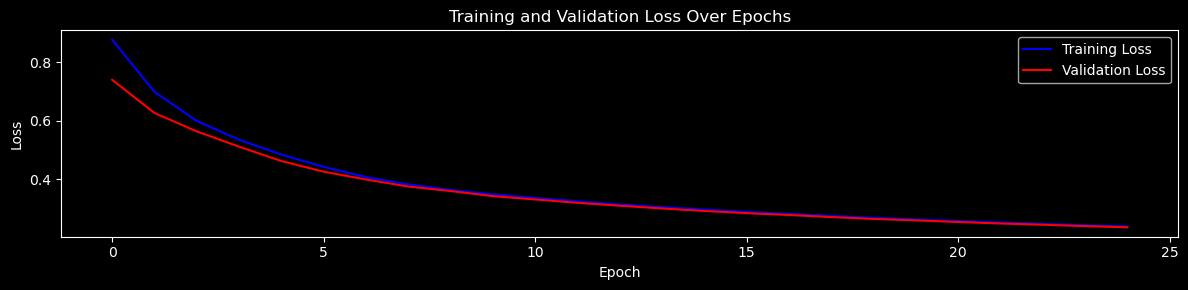

In [45]:
plt.figure(figsize=(12,3)) # Adjusted size for a single, clear plot

# Plot both lines on the same axis
plt.plot(history['train_loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='red')

# Set titles and labels for the single combined plot
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(False) # Re-enabled grid for better readability on a single plot
plt.legend()

plt.tight_layout()
plt.show()

Original pred shape: (1, 1, 256, 256)
After squeeze shape: (256, 256)



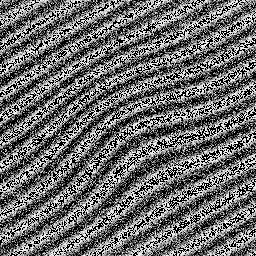
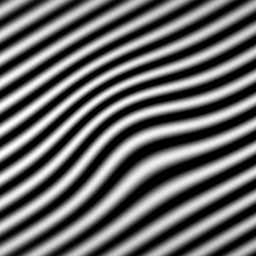
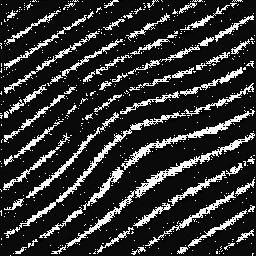

In [59]:
# Load best model
model.load_state_dict(torch.load(MODEL_OUTPUT_DIR / "best_model.pth"))
model.eval()
# Get random images
input_path, target_path = helper.get_images_from_dirs([INPUT_DIR, TARGET_DIR])
# Load and preprocess
img_pil = Image.open(input_path).convert('L')
mask_pil = Image.open(target_path).convert('L')

img_resized = img_pil.resize((HEIGHT, WIDTH))
img_tensor = torch.from_numpy(np.array(img_resized).astype(np.float32) / 255.0).unsqueeze(0).to(device)
img_tensor = img_tensor.unsqueeze(0)  # This makes it (1, 1, H, W)

# Predict
with torch.no_grad():
    pred = model(img_tensor).cpu().numpy()

print(f"Original pred shape: {pred.shape}")
pred = pred.squeeze() # This converts (1, 1, 256, 256) -> (256, 256)
print(f"After squeeze shape: {pred.shape}")

# Convert for visualization
img_np = np.array(img_resized)
mask_np = np.array(mask_pil.resize((HEIGHT, WIDTH))) / 255.0

# Display using helper
helper.show_grid({
    'Noise Mask': (img_np * 255).astype(np.uint8),
    'Target Mask': (mask_np * 255).astype(np.uint8),
    'Predicted Mask': (pred * 255).astype(np.uint8),  # Now this is 2D
}, grid="row", width=1200)